# Detectron2 Tutorial


# Install detectron2

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
import numpy as np
import pandas as pd
import os
import time
import copy

In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import Keypoints

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Prefix data directory #데이터가 있는 경로 넣기 #local 폴더 하나 만들기
prefix_dir = '/content/drive/MyDrive/1. open'

# Top level data directory. Here we assume the format of the directory conforms
# to the ImageFolder structure
train_dir = f'{prefix_dir}/train_imgs'

# Number of classes in the dataset
num_classes = 48

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs and earlystop to train for
num_epochs = 80

num_splits = 10
num_earlystop = 10

# Iput size for resize imgae
input_w = 150
input_h = 150

# Learning rate for optimizer
learning_rate = 0.05

# Flag for feature extracting. When False, we finetune the whole model,
# when True we only update the reshaped layer params
feature_extract = False

# Run a pre-trained detectron2 model

download an image from the dataset:

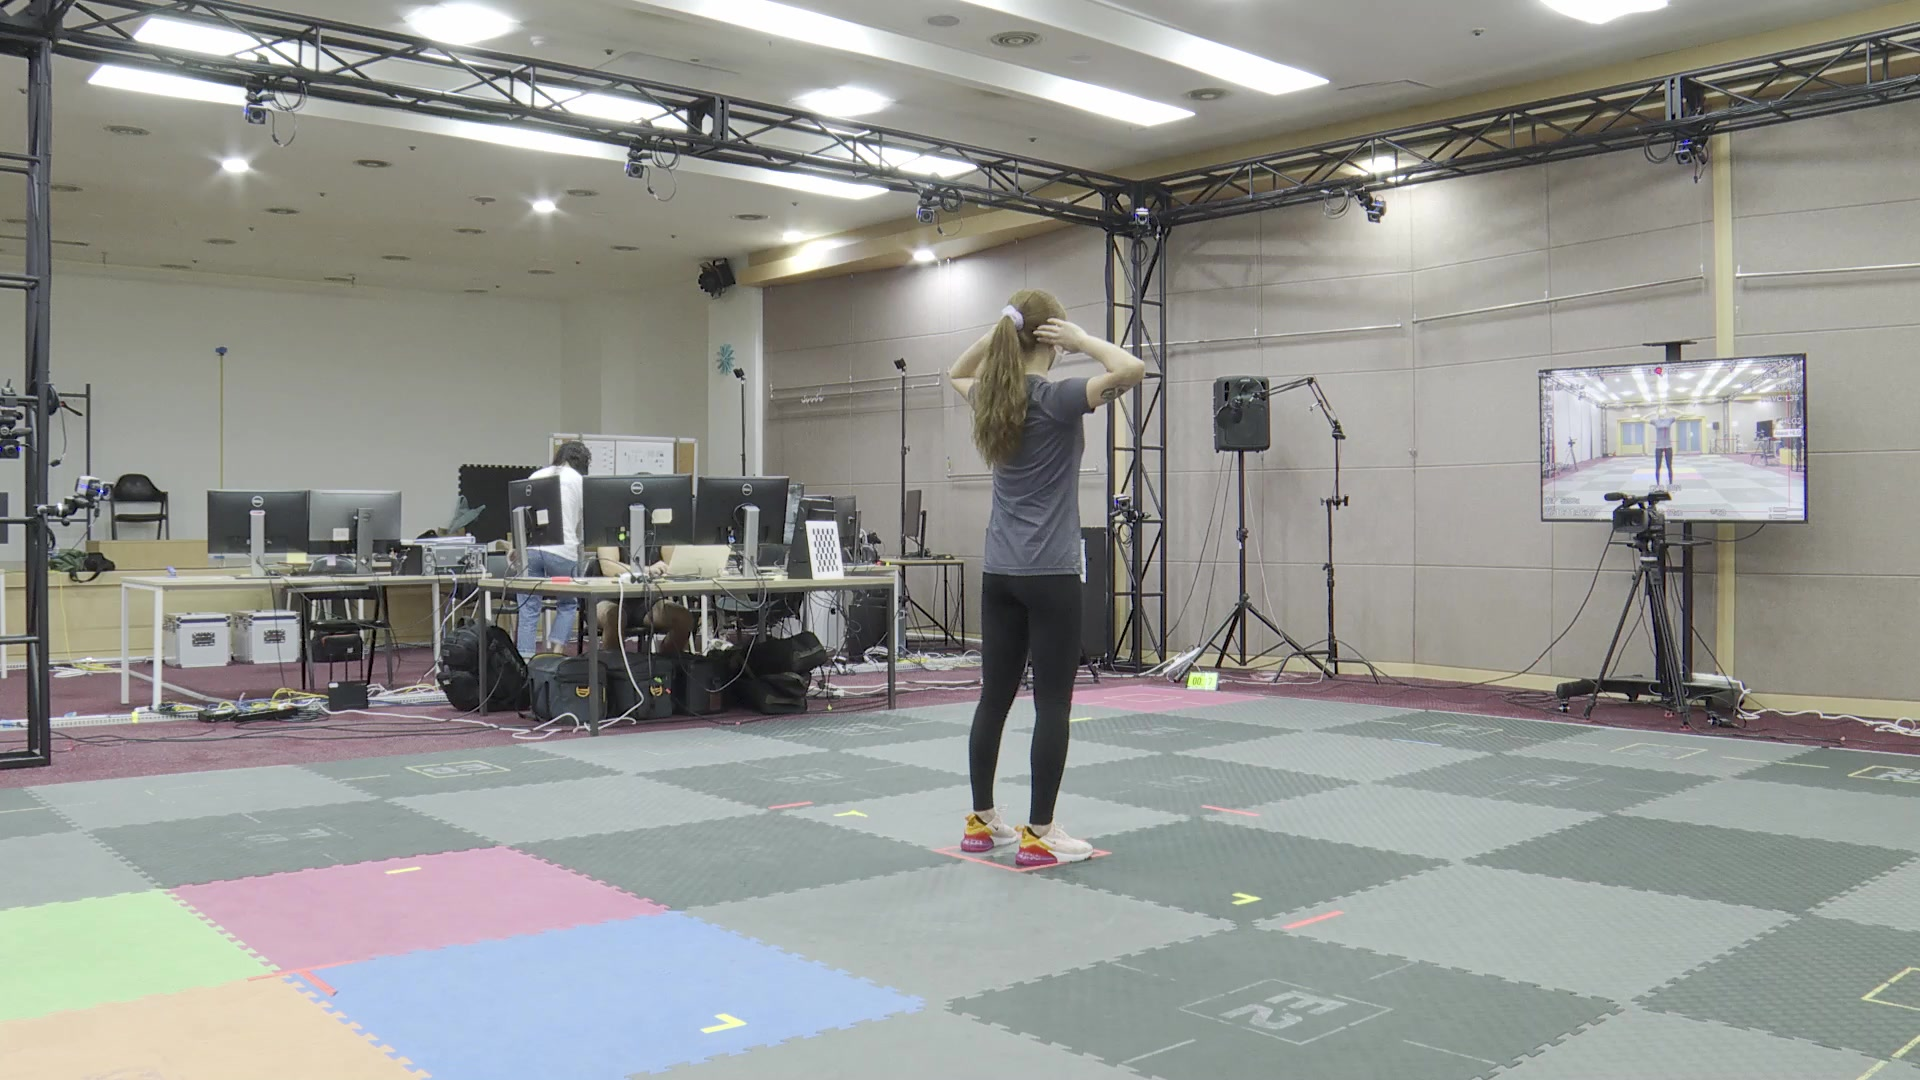

In [ ]:

im = cv2.imread("/content/drive/MyDrive/1. open/train_imgs/001-1-1-01-Z17_A-0000001.jpg")
cv2_imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

model_final_f10217.pkl: 178MB [00:02, 66.4MB/s]                           


In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 0, 62, 62, 56, 24, 62, 63, 62, 62, 56], device='cuda:0')
Boxes(tensor([[ 952.0654,  286.6455, 1144.0184,  854.7850],
        [ 688.4714,  473.7112,  793.0294,  542.7241],
        [ 213.6810,  490.4313,  309.9377,  553.7673],
        [ 299.7259,  583.8625,  387.5401,  696.4251],
        [ 439.5315,  615.4193,  532.4633,  714.5391],
        [ 514.4474,  466.4997,  583.9367,  554.7656],
        [ 802.4047,  514.9906,  860.4142,  578.1780],
        [ 308.5322,  487.0882,  398.7969,  553.8310],
        [1531.4391,  351.1203, 1811.9479,  541.4202],
        [ 110.3928,  472.6779,  169.9229,  541.8779]], device='cuda:0'))


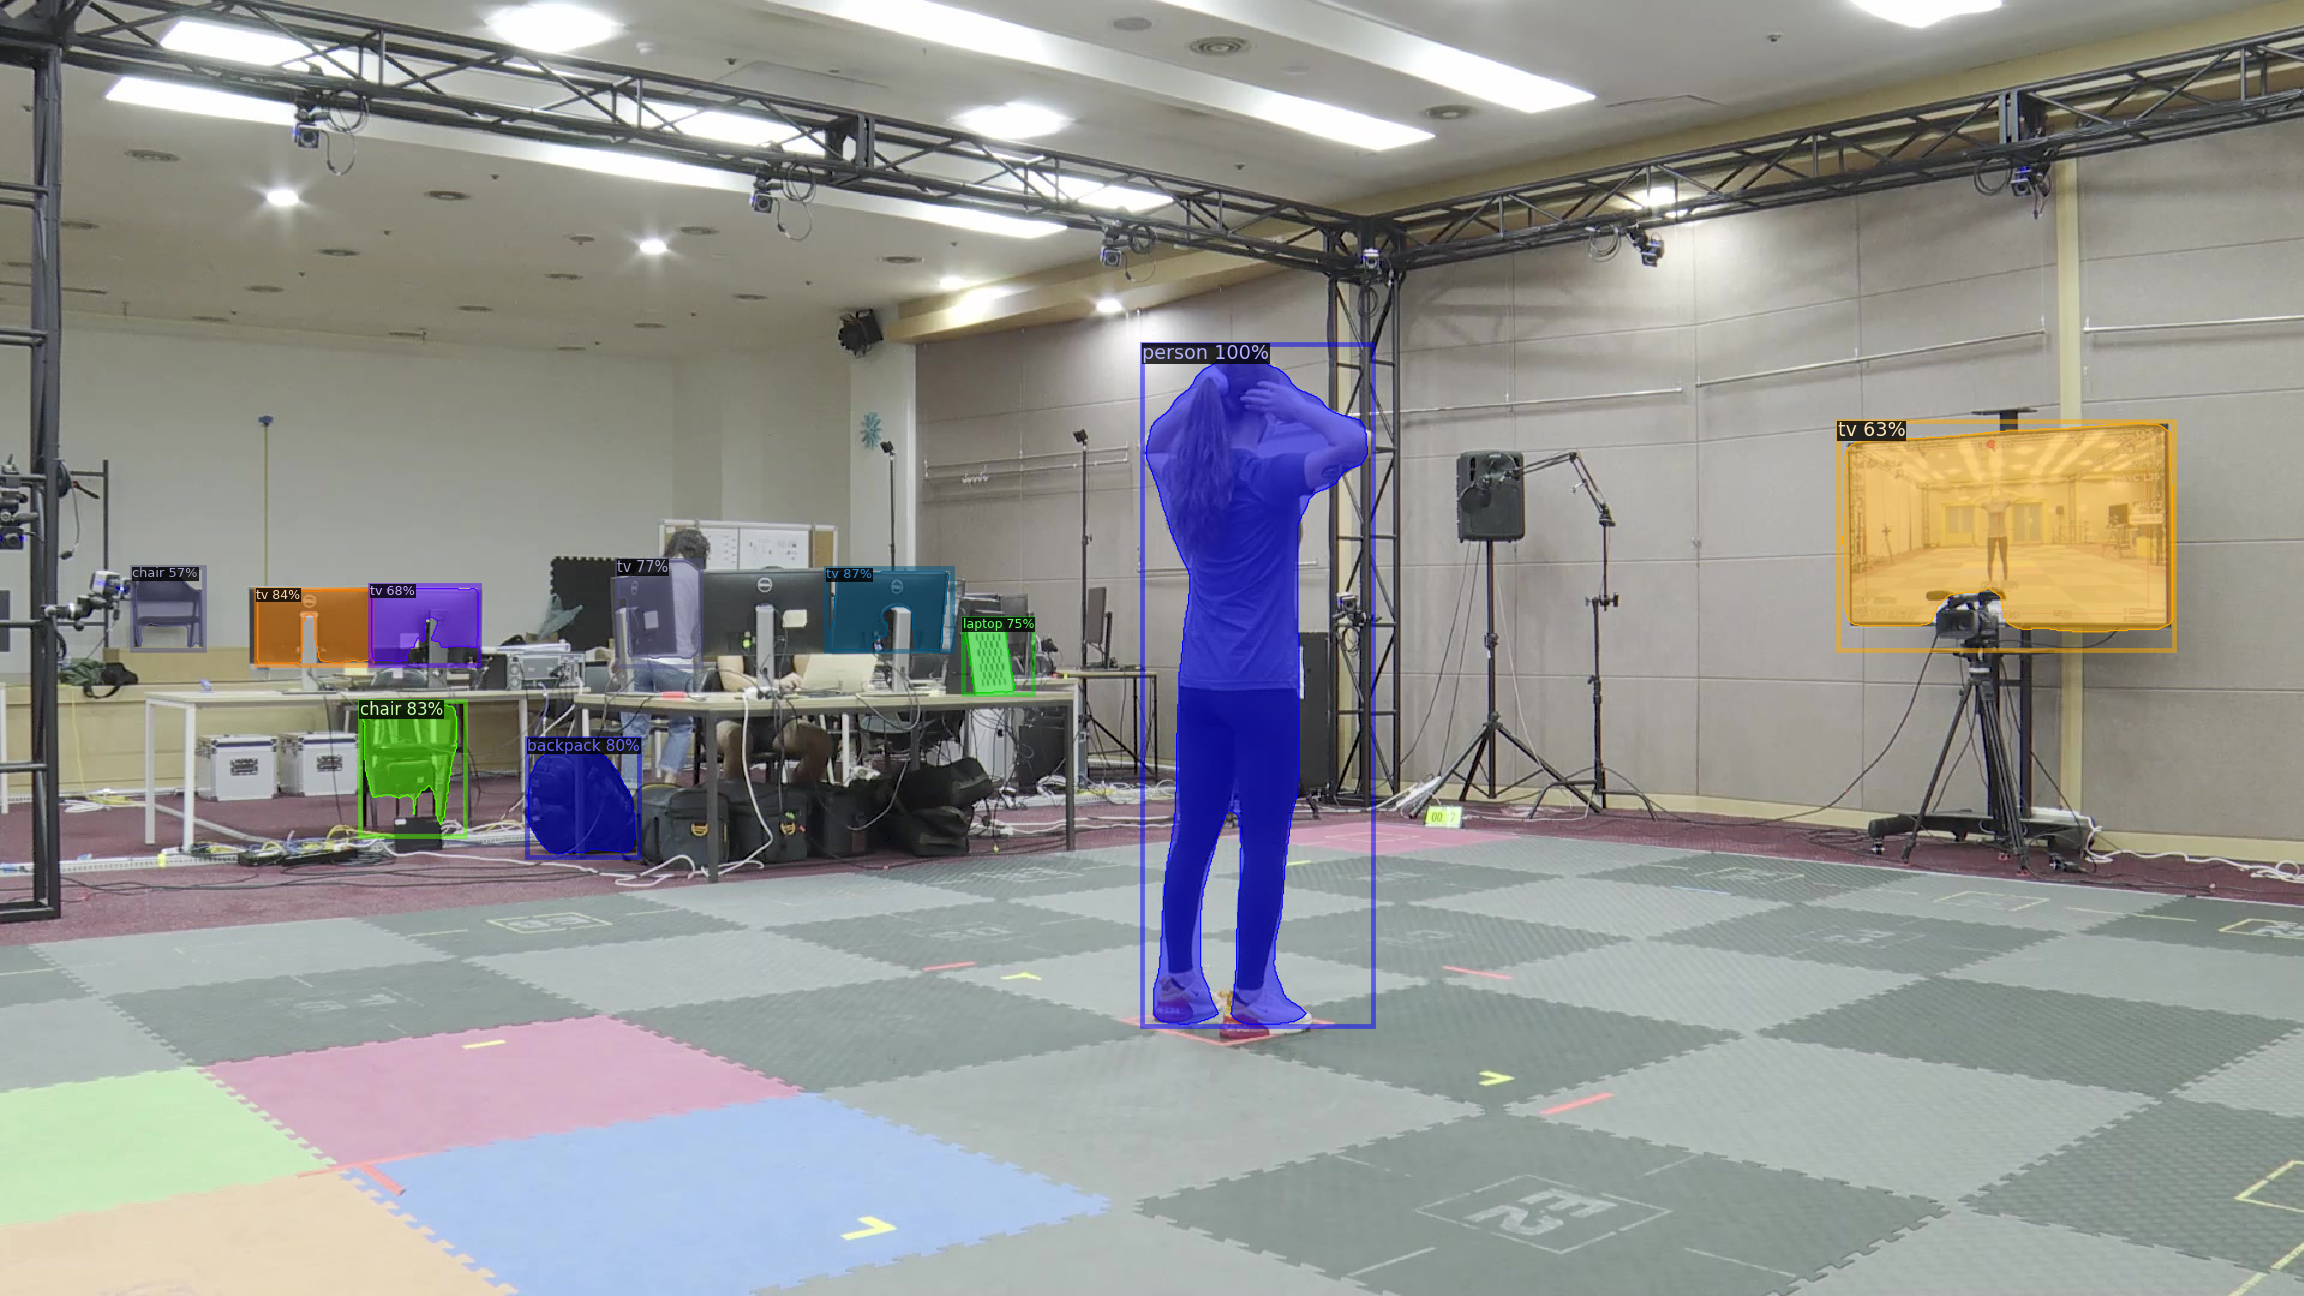

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the balloon segmentation dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)
which only has one class: balloon.
We'll train a balloon segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "balloon" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

In [ ]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

To verify the data loading is correct, let's visualize the annotations ofrandomly selected samples in the training set:



In [ ]:
dataset_dicts = get_balloon_dicts(train_dir)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()


# Inference with a keypoint detection model
cfg = get_cfg()   # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
# v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)\
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
result = Keypoints.heatmaps_to_keypoints(outputs)
print(result)
# cv2_imshow(out.get_image()[:, :, ::-1])

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts(f'{prefix_dir}/sample_submission.csv')
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])


We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70. Not bad!

# Other types of builtin models

We showcase simple demos of other types of models below:

In [ ]:
class Keypoints:
    """
    Stores keypoint **annotation** data. GT Instances have a `gt_keypoints` property
    containing the x,y location and visibility flag of each keypoint. This tensor has shape
    (N, K, 3) where N is the number of instances and K is the number of keypoints per instance.
    The visibility flag follows the COCO format and must be one of three integers:
    * v=0: not labeled (in which case x=y=0)
    * v=1: labeled but not visible
    * v=2: labeled and visible
    """

    def __init__(self, keypoints: Union[torch.Tensor, np.ndarray, List[List[float]]]):
        """
        Arguments:
            keypoints: A Tensor, numpy array, or list of the x, y, and visibility of each keypoint.
                The shape should be (N, K, 3) where N is the number of
                instances, and K is the number of keypoints per instance.
        """
        device = keypoints.device if isinstance(keypoints, torch.Tensor) else torch.device("cpu")
        keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
        assert keypoints.dim() == 3 and keypoints.shape[2] == 3, keypoints.shape
        self.tensor = keypoints

    def __len__(self) -> int:
        return self.tensor.size(0)

    def to(self, *args: Any, **kwargs: Any) -> "Keypoints":
        return type(self)(self.tensor.to(*args, **kwargs))

    @property
    def device(self) -> torch.device:
        return self.tensor.device

    def to_heatmap(self, boxes: torch.Tensor, heatmap_size: int) -> torch.Tensor:
        """
        Convert keypoint annotations to a heatmap of one-hot labels for training,
        as described in :paper:`Mask R-CNN`.
        Arguments:
            boxes: Nx4 tensor, the boxes to draw the keypoints to
        Returns:
            heatmaps:
                A tensor of shape (N, K), each element is integer spatial label
                in the range [0, heatmap_size**2 - 1] for each keypoint in the input.
            valid:
                A tensor of shape (N, K) containing whether each keypoint is in the roi or not.
        """
        return _keypoints_to_heatmap(self.tensor, boxes, heatmap_size)

    def __getitem__(self, item: Union[int, slice, torch.BoolTensor]) -> "Keypoints":
        """
        Create a new `Keypoints` by indexing on this `Keypoints`.
        The following usage are allowed:
        1. `new_kpts = kpts[3]`: return a `Keypoints` which contains only one instance.
        2. `new_kpts = kpts[2:10]`: return a slice of key points.
        3. `new_kpts = kpts[vector]`, where vector is a torch.ByteTensor
           with `length = len(kpts)`. Nonzero elements in the vector will be selected.
        Note that the returned Keypoints might share storage with this Keypoints,
        subject to Pytorch's indexing semantics.
        """
        if isinstance(item, int):
            return Keypoints([self.tensor[item]])
        return Keypoints(self.tensor[item])

    def __repr__(self) -> str:
        s = self.__class__.__name__ + "("
        s += "num_instances={})".format(len(self.tensor))
        return s


# TODO make this nicer, this is a direct translation from C2 (but removing the inner loop)
def _keypoints_to_heatmap(
    keypoints: torch.Tensor, rois: torch.Tensor, heatmap_size: int
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Encode keypoint locations into a target heatmap for use in SoftmaxWithLoss across space.
    Maps keypoints from the half-open interval [x1, x2) on continuous image coordinates to the
    closed interval [0, heatmap_size - 1] on discrete image coordinates. We use the
    continuous-discrete conversion from Heckbert 1990 ("What is the coordinate of a pixel?"):
    d = floor(c) and c = d + 0.5, where d is a discrete coordinate and c is a continuous coordinate.
    Arguments:
        keypoints: tensor of keypoint locations in of shape (N, K, 3).
        rois: Nx4 tensor of rois in xyxy format
        heatmap_size: integer side length of square heatmap.
    Returns:
        heatmaps: A tensor of shape (N, K) containing an integer spatial label
            in the range [0, heatmap_size**2 - 1] for each keypoint in the input.
        valid: A tensor of shape (N, K) containing whether each keypoint is in
            the roi or not.
    """

    if rois.numel() == 0:
        return rois.new().long(), rois.new().long()
    offset_x = rois[:, 0]
    offset_y = rois[:, 1]
    scale_x = heatmap_size / (rois[:, 2] - rois[:, 0])
    scale_y = heatmap_size / (rois[:, 3] - rois[:, 1])

    offset_x = offset_x[:, None]
    offset_y = offset_y[:, None]
    scale_x = scale_x[:, None]
    scale_y = scale_y[:, None]

    x = keypoints[..., 0]
    y = keypoints[..., 1]

    x_boundary_inds = x == rois[:, 2][:, None]
    y_boundary_inds = y == rois[:, 3][:, None]

    x = (x - offset_x) * scale_x
    x = x.floor().long()
    y = (y - offset_y) * scale_y
    y = y.floor().long()

    x[x_boundary_inds] = heatmap_size - 1
    y[y_boundary_inds] = heatmap_size - 1

    valid_loc = (x >= 0) & (y >= 0) & (x < heatmap_size) & (y < heatmap_size)
    vis = keypoints[..., 2] > 0
    valid = (valid_loc & vis).long()

    lin_ind = y * heatmap_size + x
    heatmaps = lin_ind * valid

    return heatmaps, valid


@script_if_tracing
def heatmaps_to_keypoints(maps: torch.Tensor, rois: torch.Tensor) -> torch.Tensor:
    """
    Extract predicted keypoint locations from heatmaps.
    Args:
        maps (Tensor): (#ROIs, #keypoints, POOL_H, POOL_W). The predicted heatmap of logits for
            each ROI and each keypoint.
        rois (Tensor): (#ROIs, 4). The box of each ROI.
    Returns:
        Tensor of shape (#ROIs, #keypoints, 4) with the last dimension corresponding to
        (x, y, logit, score) for each keypoint.
    When converting discrete pixel indices in an NxN image to a continuous keypoint coordinate,
    we maintain consistency with :meth:`Keypoints.to_heatmap` by using the conversion from
    Heckbert 1990: c = d + 0.5, where d is a discrete coordinate and c is a continuous coordinate.
    """
    # The decorator use of torch.no_grad() was not supported by torchscript.
    # https://github.com/pytorch/pytorch/issues/44768
    maps = maps.detach()
    rois = rois.detach()

    offset_x = rois[:, 0]
    offset_y = rois[:, 1]

    widths = (rois[:, 2] - rois[:, 0]).clamp(min=1)
    heights = (rois[:, 3] - rois[:, 1]).clamp(min=1)
    widths_ceil = widths.ceil()
    heights_ceil = heights.ceil()

    num_rois, num_keypoints = maps.shape[:2]
    xy_preds = maps.new_zeros(rois.shape[0], num_keypoints, 4)

    width_corrections = widths / widths_ceil
    height_corrections = heights / heights_ceil

    keypoints_idx = torch.arange(num_keypoints, device=maps.device)

    for i in range(num_rois):
        outsize = (int(heights_ceil[i]), int(widths_ceil[i]))
        roi_map = F.interpolate(
            maps[[i]], size=outsize, mode="bicubic", align_corners=False
        ).squeeze(
            0
        )  # #keypoints x H x W

        # softmax over the spatial region
        max_score, _ = roi_map.view(num_keypoints, -1).max(1)
        max_score = max_score.view(num_keypoints, 1, 1)
        tmp_full_resolution = (roi_map - max_score).exp_()
        tmp_pool_resolution = (maps[i] - max_score).exp_()
        # Produce scores over the region H x W, but normalize with POOL_H x POOL_W,
        # so that the scores of objects of different absolute sizes will be more comparable
        roi_map_scores = tmp_full_resolution / tmp_pool_resolution.sum((1, 2), keepdim=True)

        w = roi_map.shape[2]
        pos = roi_map.view(num_keypoints, -1).argmax(1)

        x_int = pos % w
        y_int = (pos - x_int) // w

        assert (
            roi_map_scores[keypoints_idx, y_int, x_int]
            == roi_map_scores.view(num_keypoints, -1).max(1)[0]
        ).all()

        x = (x_int.float() + 0.5) * width_corrections[i]
        y = (y_int.float() + 0.5) * height_corrections[i]

        xy_preds[i, :, 0] = x + offset_x[i]
        xy_preds[i, :, 1] = y + offset_y[i]
        xy_preds[i, :, 2] = roi_map[keypoints_idx, y_int, x_int]
        xy_preds[i, :, 3] = roi_map_scores[keypoints_idx, y_int, x_int]

    return xy_preds

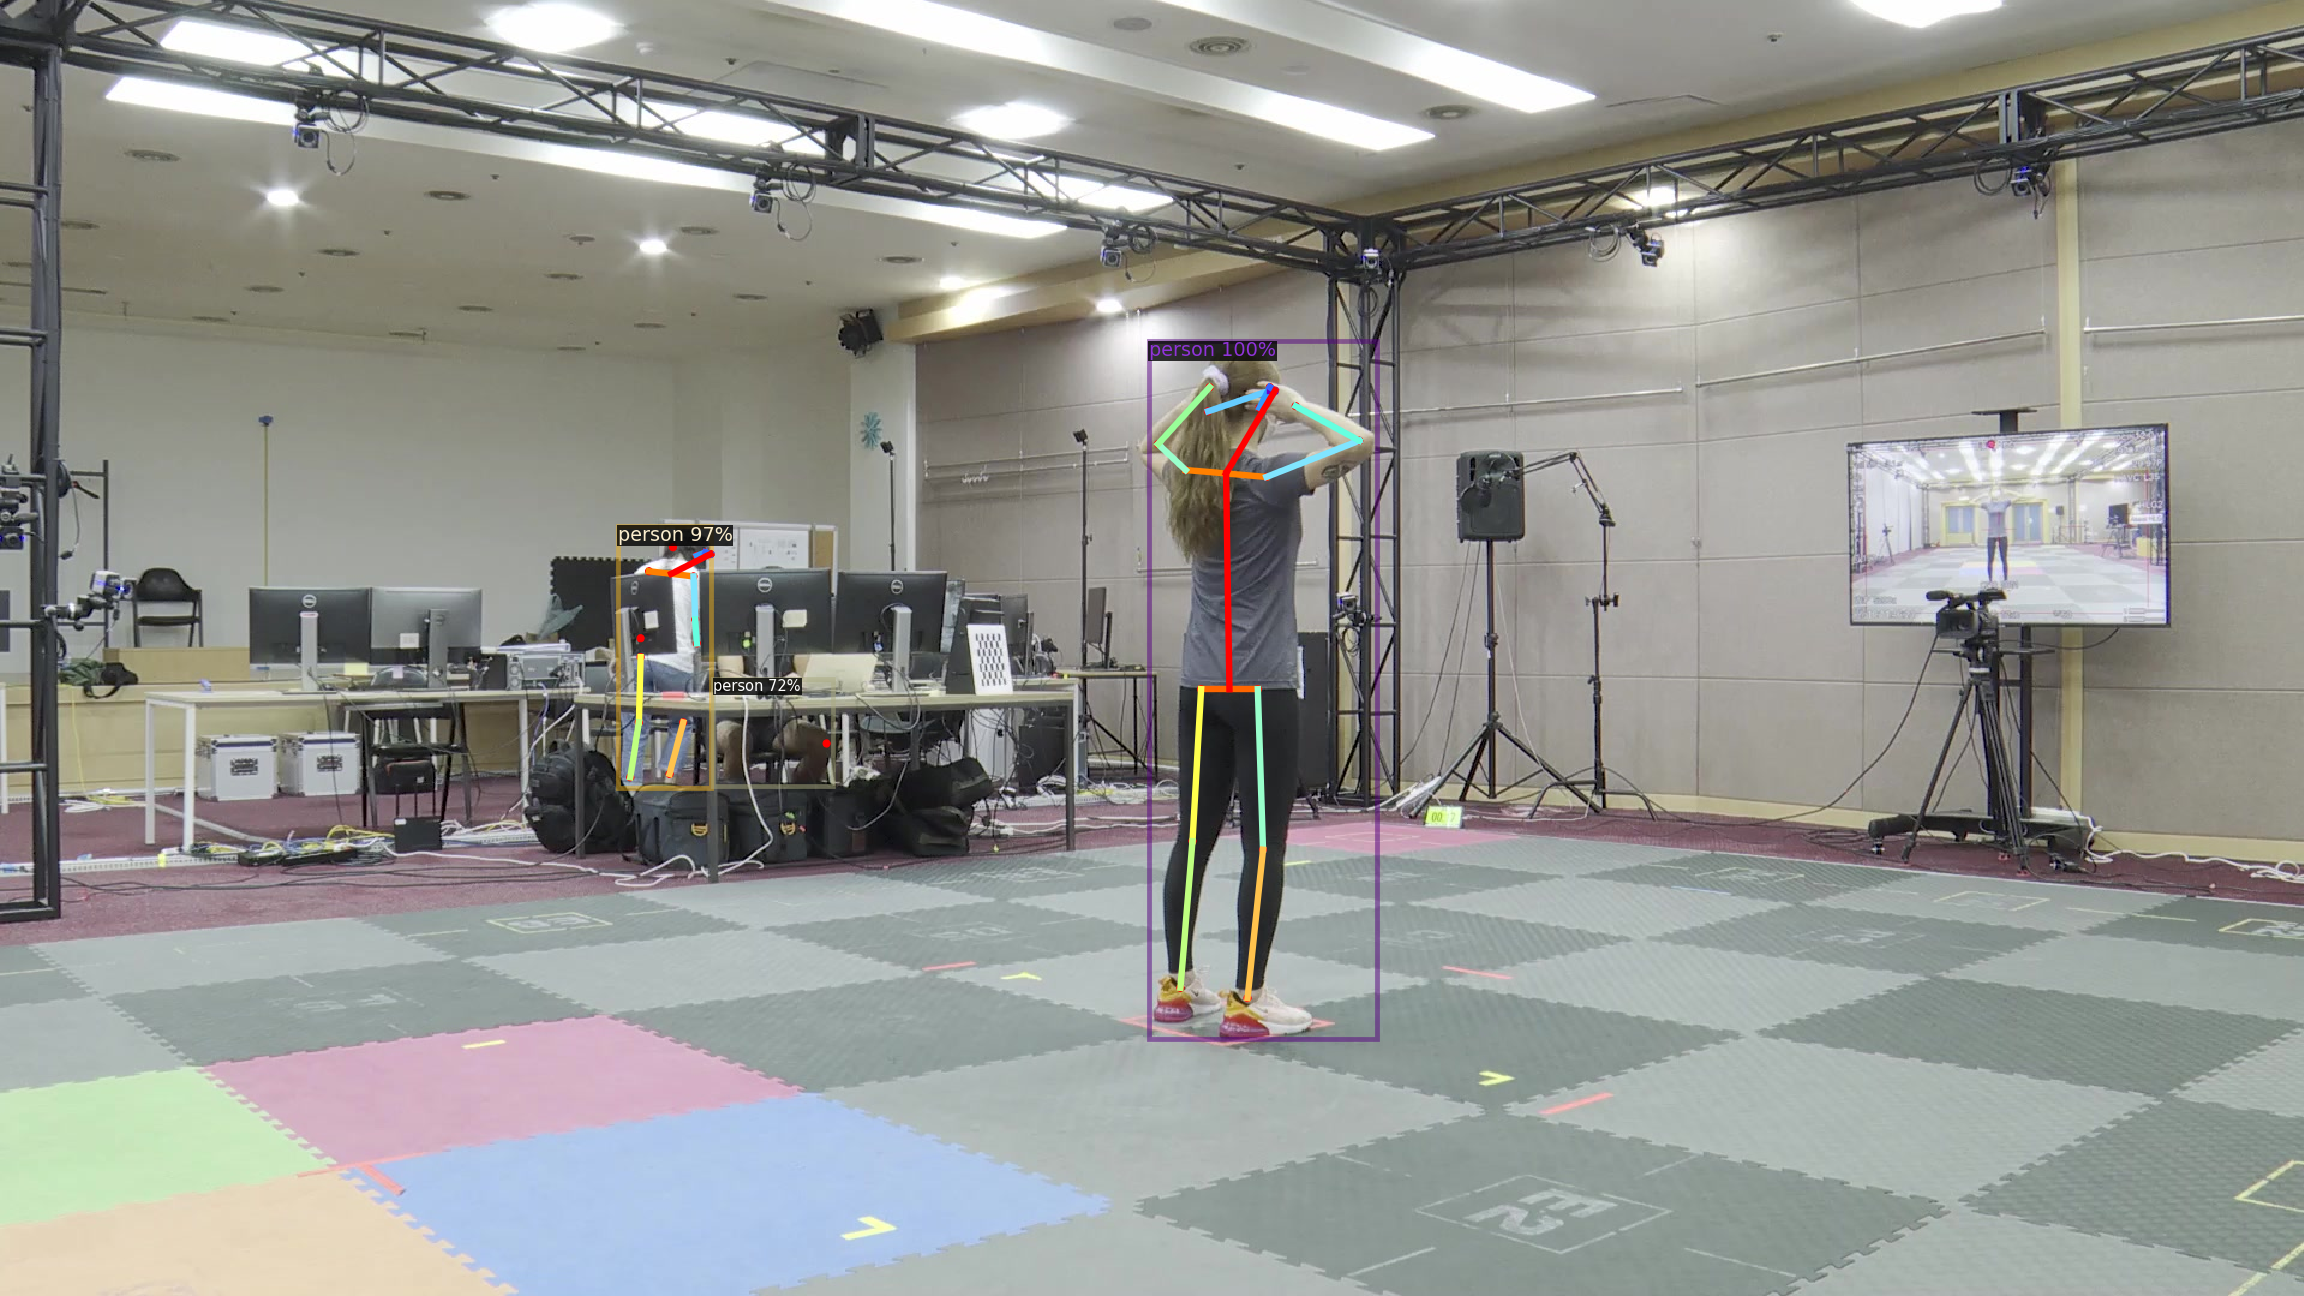

In [ ]:
# Inference with a keypoint detection model
cfg = get_cfg()   # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])